Bonjour à tous

Bienvenue dans notre notebook partie II dédié au projet "FarmPyStep" et issu de la base de donnée Agribalyse 3.0

Une vidéo de présentation est disponible dans le lien ci-contre : https://youtu.be/DNdv0TbxJgc

**Description du projet**

Le programme Agribalyse® produit des données de référence sur les impacts environnementaux des produits agricoles et alimentaires. Les méthodologies et les données ont été élaborées et validées dans le cadre d’un partenariat veillant à leur qualité et leur transparence (ADEME, INRAE, les instituts techniques agricoles et agroalimentaires, des experts indépendants et des cabinets d’études).

Agribalyse® est la base de données publique française la plus exhaustive d’indicateurs environnementaux des produits agricoles et alimentaires fondés sur l’Analyse du Cycle de Vie. Elle fournit des indicateurs d’impacts environnementaux :

*   des principales productions agricoles françaises,
*   des principaux produits alimentaires consommés en France.

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**# 1) Création d'un score pour les agricultures conv/bio à partir du 
tableau de pondération EF3**

In [ ]:
#Nous importons les packages nécessaires
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Nous chargeons le fichier "AGRIBALYSE3_partie agriculture_bio.xlsx" dans un Dataframe appelé df_agri_bio
df_agri_bio = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Agribalyse 3.0/AGRIBALYSE3_partie_agriculture_bio.xlsx', sheet_name=1, header=2)
df_agri_bio.head()

,Nom du Produit en Français (traduction approximative googleTranslate),"Complément d'information, voir rapport ACV Bio pour détails",LCI Name,Catégorie,Source,kg CO2 eq,kg CFC11 eq,kBq U-235 eq,kg NMVOC eq,disease inc.,mol H+ eq,kg P eq,kg N eq,mol N eq,CTUe,Pt,m3 depriv.,MJ,kg Sb eq,kg CO2 eq.1,kg CO2 eq.2,kg CO2 eq.3
0,"Poulet, biologique, système n ° 1, à la ferme ...",Alimentation à 100% biologique,"Chicken, organic, system n°1, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,"Projet ACV Bio, Agribalyse; INRAE",3.367223,2.231341e-07,0.370369,0.009739,6.406827e-07,0.096769,0.001108,0.035875,0.419020,23.943988,1255.448933,11.545991,24.340806,0.000004,2.402503,0.072984,0.891736
1,"Poulet, biologique, système n ° 2, à la ferme ...",Alimentation à 95% biologique,"Chicken, organic, system n°2, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,"Projet ACV Bio, Agribalyse; INRAE",3.356220,2.191613e-07,0.346624,0.009975,6.268291e-07,0.095043,0.001120,0.037355,0.411431,25.312177,1317.464328,10.594972,23.510417,0.000004,2.385977,0.072831,0.897412
2,"Poule Réforme, biologique, système n ° 1, à la...",Alimentation à 100% biologique,"Cull hen, organic, system n°1, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,"Projet ACV Bio, Agribalyse; INRAE",9.145963,7.245766e-07,1.279462,0.028435,2.124903e-06,0.309146,0.002282,0.057769,1.342457,20.056840,1713.079759,13.319835,83.758480,0.000013,7.318569,0.254163,1.573232
3,"Poule Réforme, biologique, système n ° 2, à la...",Alimentation à 95% biologique,"Cull hen, organic, system n°2, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,"Projet ACV Bio, Agribalyse; INRAE",9.145963,7.245766e-07,1.279462,0.028435,2.124903e-06,0.309146,0.002282,0.057769,1.342457,20.056840,1713.079759,13.319835,83.758480,0.000013,7.318569,0.254163,1.573232
4,"Oeuf, biologique, système n ° 1, à la ferme / ...",Alimentation à 100% biologique,"Egg, organic, system n°1, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,"Projet ACV Bio, Agribalyse; INRAE",2.332804,1.363164e-07,0.313186,0.006614,5.580887e-07,0.083031,0.000811,0.029258,0.362548,14.260966,921.649335,9.761379,15.523990,0.000003,1.500865,0.075275,0.756665


In [ ]:
#Nous chargeons le fichier "AGRIBALYSE3_partie agriculture_conv.xlsx" dans un Dataframe appelé df_agri_conv
df_agri_conv = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Agribalyse 3.0/AGRIBALYSE3_partie_agriculture_conv.xlsx', sheet_name=1, header=2)
df_agri_conv.head()

,Nom du Produit en Français (traduction approximative GoogleTranslate),LCI Name,Catégorie,kg CO2 eq,kg CFC11 eq,kBq U-235 eq,kg NMVOC eq,disease inc.,mol H+ eq,kg P eq,kg N eq,mol N eq,CTUe,Pt,m3 depriv.,MJ,kg Sb eq,kg CO2 eq.1,kg CO2 eq.2,kg CO2 eq.3
0,"Poulet, Bleu Blanc Coeur, at farm gate/FR U","Broiler; Bleu Blanc Coeur, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.447444,1.114543e-07,0.170576,0.004625,3.201402e-07,0.047212,0.000410,0.012102,0.206126,7.076016,407.081278,2.800084,11.744189,0.000002,1.212746,0.052433,0.182264
1,"Poulet, conventionnel, départ ferme / FR U","Broiler, conventional, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.874528,1.450691e-07,0.219829,0.006330,3.384269e-07,0.049391,0.000515,0.011752,0.212471,4.414016,361.946447,3.171305,15.153821,0.000003,1.384915,0.050339,0.439274
2,"Poulet, Label Rouge, à la de la ferme / FR U","Broiler, Label Rouge, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,2.826588,2.127715e-07,0.282615,0.008856,5.477897e-07,0.080092,0.000696,0.019295,0.346505,6.229281,590.334835,4.138621,22.510811,0.000004,2.269230,0.065364,0.491993
3,"Poulet, moyenne nationale, à la de la ferme /...","Broiler, national average, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.991910,1.534682e-07,0.227954,0.006645,3.648120e-07,0.053261,0.000538,0.012754,0.229395,4.643459,393.391784,3.296539,16.075367,0.000003,1.496097,0.052283,0.443529
4,"Canard à rôtir, conventionnel, à la ferme / FR U","Duck for roasting, conventional, at farm gate/...",Agricultural\Animal production\Avian\Transform...,2.739946,1.775418e-07,0.259452,0.008043,6.456014e-07,0.094042,0.000629,0.017566,0.411137,6.798170,526.520774,3.532655,18.206610,0.000003,1.558892,0.738867,0.442187


In [ ]:
#Nous chargeons le fichier "tableau de ponderation EF3.xlsx" dans un Dataframe appelé df_ponderation
df_ponderation = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Agribalyse 3.0/Tableau_de_ponderation_EF3.xlsx')
df_ponderation.head()

,Original_Title,French_Title,Aggregated weighting set,Robustness factors,Intermediate Coefficients,Final weighting factors (incl. robustness)
0,Climatte change,Changement climatique,12.90,0.87,11.18,21.06
1,Ozone depletion,Appauvrissement de la couche d’ozone,5.58,0.60,3.35,6.31
2,"Human toxicity, cancer effects",Toxicité humaine cancérigène,6.80,0.17,1.13,2.13
3,"Human toxicity, non-cancer effects",Toxicité humaine non cancérigène,5.88,0.17,0.98,1.84
4,Particulate matter,Particules fines,5.49,0.87,4.76,8.96


In [ ]:
# Création des dictionnaires associant les anciens noms aux nouveaux noms de colonnes
dict_agri_conv = {
    'Nom du Produit en Français (traduction approximative GoogleTranslate)': 'Name',
    'LCI Name': 'LCI_Name',
    'Catégorie': 'Categorie',
    'kg CO2 eq': 'Changement climatique',
    'kg CFC11 eq': 'Appauvrissement de la couche d’ozone',
    'kBq U-235 eq': 'Radiation ionisante, effet sur la santé',
    'kg NMVOC eq': 'Formation photochimique d’ozone',
    'disease inc.': 'Particules fines',
    'mol H+ eq': 'Acidification',
    'kg P eq': 'Eutrophisation, eau douce',
    'kg N eq': 'Eutrophisation, marine',
    'mol N eq': 'Eutrophisation, terrestre',
    'CTUe': 'Ecotoxicité d\'eau douce',
    'Pt': 'Usage des terres',
    'm3 depriv.': 'Épuisement des ressources en eau',
    'MJ': 'Épuisement des ressources énergétiques',
    'kg Sb eq': 'Épuisement des ressources - minéraux',
    'kg CO2 eq.1': 'Climate_Change_Fossil',
    'kg CO2 eq.2': 'Climate_Change_Biogenic',
    'kg CO2 eq.3': 'Climate_Change_Land_Use_And_Transform'
}

dict_agri_bio = {
    'Nom du Produit en Français (traduction approximative googleTranslate)': 'Name',
    'Complément d\'information, voir rapport ACV Bio pour détails': 'Additional_Information',
    'LCI Name' : 'LCI_Name',
    'Catégorie' : 'Categorie',
    'kg CO2 eq': 'Changement climatique',
    'kg CFC11 eq': 'Appauvrissement de la couche d’ozone',
    'kBq U-235 eq': 'Radiation ionisante, effet sur la santé',
    'kg NMVOC eq': 'Formation photochimique d’ozone',
    'disease inc.': 'Particules fines',
    'mol H+ eq': 'Acidification',
    'kg P eq': 'Eutrophisation, eau douce',
    'kg N eq': 'Eutrophisation, marine',
    'mol N eq': 'Eutrophisation, terrestre',
    'CTUe': 'Ecotoxicité d\'eau douce',
    'Pt': 'Usage des terres',
    'm3 depriv.': 'Épuisement des ressources en eau',
    'MJ': 'Épuisement des ressources énergétiques',
    'kg Sb eq': 'Épuisement des ressources - minéraux',
    'kg CO2 eq.1': 'Climate_Change_Fossil',
    'kg CO2 eq.2': 'Climate_Change_Biogenic',
    'kg CO2 eq.3': 'Climate_Change_Land_Use_And_Transform'
}

# On renomme les variables
df_agri_conv.rename(dict_agri_conv, axis = 1, inplace=True)
df_agri_bio.rename(dict_agri_bio, axis = 1, inplace=True)

# Nous renommons les variables
df_agri_conv.rename(dict_agri_conv, axis = 1, inplace=True)
df_agri_bio.rename(dict_agri_bio, axis = 1, inplace=True)

# Le dataframe df_agri_bio contient 2 colonnes supplémentaire non indispensable pour l'étude
# Suppression de ces 2 colonnes
df_agri_bio.drop(['Additional_Information', 'Source'], axis=1, inplace=True)

In [ ]:
# On visualise les valeurs manquantes sur le dataframe df_agri_bio
df_agri_bio[df_agri_bio.isna().any(axis = 1)]

,Name,LCI_Name,Categorie,Changement climatique,Appauvrissement de la couche d’ozone,"Radiation ionisante, effet sur la santé",Formation photochimique d’ozone,Particules fines,Acidification,"Eutrophisation, eau douce","Eutrophisation, marine","Eutrophisation, terrestre",Ecotoxicité d'eau douce,Usage des terres,Épuisement des ressources en eau,Épuisement des ressources énergétiques,Épuisement des ressources - minéraux,Climate_Change_Fossil,Climate_Change_Biogenic,Climate_Change_Land_Use_And_Transform
58,"Paille de blé, biologique, système n ° 1, à la...","Wheat straw, organic, system n°1, at farm gate...",Agricultural\Plant production\Cereals\Transfor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,"Paille de blé, biologique, système n ° 2, à la...","Wheat straw, organic, system n°2, at farm gate...",Agricultural\Plant production\Cereals\Transfor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# On visualise les valeurs manquantes sur le dataframe df_agri_conv
df_agri_conv[df_agri_conv.isna().any(axis = 1)]

,Name,LCI_Name,Categorie,Changement climatique,Appauvrissement de la couche d’ozone,"Radiation ionisante, effet sur la santé",Formation photochimique d’ozone,Particules fines,Acidification,"Eutrophisation, eau douce","Eutrophisation, marine","Eutrophisation, terrestre",Ecotoxicité d'eau douce,Usage des terres,Épuisement des ressources en eau,Épuisement des ressources énergétiques,Épuisement des ressources - minéraux,Climate_Change_Fossil,Climate_Change_Biogenic,Climate_Change_Land_Use_And_Transform


In [ ]:
# On visualise les valeurs manquantes sur le dataframe df_ponderation
df_ponderation[df_ponderation.isna().any(axis = 1)]

,Original_Title,French_Title,Aggregated weighting set,Robustness factors,Intermediate Coefficients,Final weighting factors (incl. robustness)


In [ ]:
# On supprime les lignes contenant au moins une valeur manquante dans df_agri_bio
df_agri_bio = df_agri_bio.dropna(axis = 0, how = 'any').reset_index(drop=True)

In [ ]:
# On supprime les lignes contenant au moins une valeur manquante dans df_ponderation
df_ponderation = df_ponderation.dropna(axis = 0, how = 'any').reset_index(drop=True)

In [ ]:
# Création d'un dictionnaire pour ayant pour clé le titre et pour valeur la pondération
ponderation_ef = pd.DataFrame(data=df_ponderation[['French_Title','Final weighting factors (incl. robustness)']])
dict_ponderation = ponderation_ef.set_index('French_Title').T.to_dict('records')
dict_ponderation = dict_ponderation[0]
dict_ponderation

{'Acidification': 6.2,
 'Appauvrissement de la couche d’ozone': 6.31,
 'Changement climatique': 21.06,
 "Ecotoxicité d'eau douce": 1.92,
 'Eutrophisation, eau douce': 2.8,
 'Eutrophisation, marine': 2.96,
 'Eutrophisation, terrestre': 3.71,
 'Formation photochimique d’ozone': 4.78,
 'Particules fines': 8.96,
 'Radiation ionisante, effet sur la santé': 5.01,
 'Toxicité humaine cancérigène': 2.13,
 'Toxicité humaine non cancérigène': 1.84,
 'Usage des terres': 7.94,
 'Épuisement des ressources - minéraux': 7.55,
 'Épuisement des ressources en eau': 8.51,
 'Épuisement des ressources énergétiques': 8.32}

In [ ]:
# Création de la fonction permettant de calculer le score
# Celle ci prend en paramétre un dataframe et un dictionnaire
def calcul_score(df, data):
    """Calcul le score EF et reourne un dataframe"""
    # La ligne ci-dessous sert a enlever l'avertissement python "SettingWithCopyWarning"
    with pd.option_context("mode.chained_assignment", None):
        df['score EF'] = np.nan
        for index in range(len(df)):
            score_item = 0
            nbre_item = 0
            for name, values in df.items():
                if name in data:
                    score_item += values[index] * (data[name]/100)
                    nbre_item += 1
            df['score EF'].iloc[index] = round(((score_item * nbre_item) / 1000),2)
        return df

In [ ]:
# On applique la fonction au deux dataframe
calcul_score(df_agri_bio, dict_ponderation)
calcul_score(df_agri_conv, dict_ponderation)

,Name,LCI_Name,Categorie,Changement climatique,Appauvrissement de la couche d’ozone,"Radiation ionisante, effet sur la santé",Formation photochimique d’ozone,Particules fines,Acidification,"Eutrophisation, eau douce","Eutrophisation, marine","Eutrophisation, terrestre",Ecotoxicité d'eau douce,Usage des terres,Épuisement des ressources en eau,Épuisement des ressources énergétiques,Épuisement des ressources - minéraux,Climate_Change_Fossil,Climate_Change_Biogenic,Climate_Change_Land_Use_And_Transform,score EF
0,"Poulet, Bleu Blanc Coeur, at farm gate/FR U","Broiler; Bleu Blanc Coeur, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.447444,1.114543e-07,0.170576,0.004625,3.201402e-07,0.047212,0.000410,0.012102,0.206126,7.076016,407.081278,2.800084,11.744189,0.000002,1.212746,0.052433,0.182264,0.48
1,"Poulet, conventionnel, départ ferme / FR U","Broiler, conventional, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.874528,1.450691e-07,0.219829,0.006330,3.384269e-07,0.049391,0.000515,0.011752,0.212471,4.414016,361.946447,3.171305,15.153821,0.000003,1.384915,0.050339,0.439274,0.43
2,"Poulet, Label Rouge, à la de la ferme / FR U","Broiler, Label Rouge, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,2.826588,2.127715e-07,0.282615,0.008856,5.477897e-07,0.080092,0.000696,0.019295,0.346505,6.229281,590.334835,4.138621,22.510811,0.000004,2.269230,0.065364,0.491993,0.70
3,"Poulet, moyenne nationale, à la de la ferme /...","Broiler, national average, at farm gate/FR U",Agricultural\Animal production\Avian\Transform...,1.991910,1.534682e-07,0.227954,0.006645,3.648120e-07,0.053261,0.000538,0.012754,0.229395,4.643459,393.391784,3.296539,16.075367,0.000003,1.496097,0.052283,0.443529,0.47
4,"Canard à rôtir, conventionnel, à la ferme / FR U","Duck for roasting, conventional, at farm gate/...",Agricultural\Animal production\Avian\Transform...,2.739946,1.775418e-07,0.259452,0.008043,6.456014e-07,0.094042,0.000629,0.017566,0.411137,6.798170,526.520774,3.532655,18.206610,0.000003,1.558892,0.738867,0.442187,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,"Coquille Saint-Jacques, BSBrieuc, Dredge, en m...","Great Scallop, BSBrieuc, Dredge, average, at l...",Fishery\Fishery products\Great Scallop - BSBri...,0.682146,1.518734e-07,0.046938,0.015236,1.531490e-07,0.022205,0.000077,0.005305,0.058093,0.239004,1.649323,0.056998,9.842771,0.000004,0.681356,0.000181,0.000610,0.02
236,"Hareng de l'Atlantique, NEA, Pelagic Chalut, e...","Atlantic Herring, NEA, Pelagic Trawl, average,...",Fishery\Fishery products\Herring - NEA - Pelag...,0.527711,1.397918e-07,0.034282,0.011424,1.150014e-07,0.016795,0.000030,0.003988,0.043676,0.110804,0.843739,0.038987,7.169146,0.000001,0.525812,0.000883,0.001017,0.01
237,"Maquereau Atlantique, NEA, Pelagic Chalut, en ...","Atlantic Mackerel, NEA, Pelagic Trawl, average...",Fishery\Fishery products\Mackerel - NEA - Pela...,0.536571,1.443375e-07,0.034631,0.011531,1.161002e-07,0.016956,0.000031,0.004025,0.044081,0.113116,0.868153,0.039549,7.240029,0.000001,0.534597,0.000918,0.001056,0.01
238,"Listao, la CEA, la Seine, en moyenne, à l'atte...","Skipjack Tuna, ECA, Seine, average, at landing...",Fishery\Fishery products\Skipjack Tuna - ECA -...,1.905473,4.262147e-07,0.132283,0.043365,4.361952e-07,0.063492,0.000128,0.015216,0.166519,0.418938,1.917761,0.175782,27.298251,0.000008,1.904308,0.000472,0.000693,0.04


**# 2) Création des paniers**

  Qu'est-ce qu'on mange en France? Quel est l'impact de notre consommation sur l'environnement? Passons aux résultats déjà disponibles de l'étude Anses. L’Anses publie les résultats de sa troisième étude sur les consommations et les habitudes alimentaires de la population française, INCA 3. Plus de 5 800 personnes (3 157 adultes âgés de 18 à 79 ans et 2 698 enfants âgés de 0 à 17 ans) ont participé à cette grande étude nationale qui a mobilisé en 2014 et 2015 près de 200 enquêteurs. 150 questions ont été posées aux participants sur leurs habitudes et modes de vie, 13 600 journées de consommations ont été recueillies, générant des données sur 320 000 aliments consommés. Les Français consomment en moyenne 2,9 kg d’aliments chaque jour, soit environ 2200 kcal, dont 50% de boissons. Les femmes privilégient généralement les yaourts et fromages blancs, les compotes, la volaille et les soupes. Quant aux hommes, ils sont plutôt amateurs de fromages, de viandes, de charcuteries, de pommes de terre et de crèmes dessert. Qu'y a-t-il dans l'assiette française? En moyenne, les enfants, jusqu’à 10 ans, consomment 1,6 kg d’aliments et de boissons par jour. Cette quantité s’élève à 2,2 kg pour les adolescents âgés de 11 à 17 ans et à 2,9 kg pour les adultes de 18 à 79 ans. Les boissons représentent plus de la moitié de cette ration journalière, et l’eau constitue la moitié des boissons consommées. D’après l’étude INCA 3, les hommes mangent plus que les femmes. Celles-ci privilégient yaourts, fromages blancs, compotes volailles, soupes et boissons chaudes. Les hommes favorisent les produits céréaliers, le fromage, les viandes et charcuteries, ou encore les crèmes dessert. Plus d'informations peuvent être trouvées sur le site Web. https://www.anses.fr/fr. Le graphique ci-dessous montre l'assiette française du jour.



In [ ]:
my_dict = {
    'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
    'Un enfant de 0 à 10 ans (%)' : [24,18,5,6,32,15],
    'Un adolescent de 11 à 17 ans (%)': [16,15,7,8,38,16],
   'Un adulte (%)': [6,16,6,6,55,11]
}

df = pd.DataFrame(my_dict)
df

,Catégorie de produit,Un enfant de 0 à 10 ans (%),Un adolescent de 11 à 17 ans (%),Un adulte (%)
0,Produits laitiers,24,16,6
1,Fruits et légumes,18,15,16
2,"Viandes, poissons, œufs",5,7,6
3,Produits céréales,6,8,6
4,Eaux et autres boissons,32,38,55
5,Autres,15,16,11


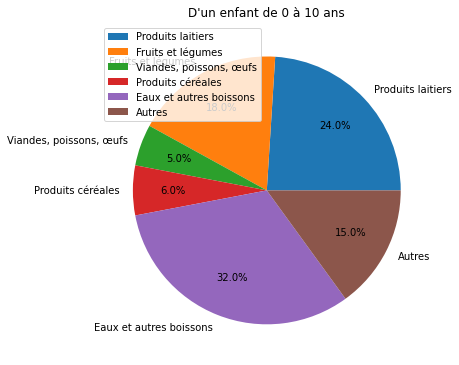

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un enfant de 0 à 10 ans")

plt.pie(df['Un enfant de 0 à 10 ans (%)'], labels=df['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');



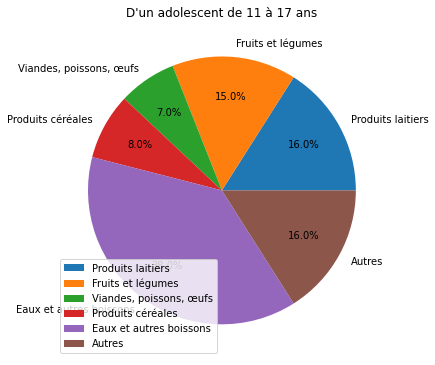

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un adolescent de 11 à 17 ans")

plt.pie(df['Un adolescent de 11 à 17 ans (%)'], labels=df['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

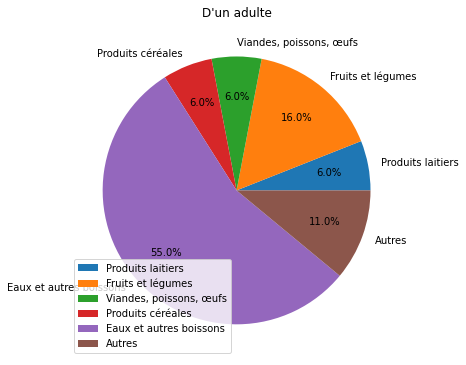

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un adulte")

plt.pie(df['Un adulte (%)'], labels=df['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

  Nous divisons les consommateurs en 7 types selon le régime alimentaire :

1. Consommation de tous les aliments
2. Flexitarien
3. Végétarisme
4. Le végétalisme
5. Régime paléo
6. Le régime céto
7. Consommation locale

Sur la base des études ci-dessus de l'INSA 3, nous calculerons l'impact de chaque personne en fonction de sa culture alimentaire. Comme mentionné ci-dessus, en moyenne, les adultes de 18 à 79 ans, consomment 2,9 kg d’aliments et de boissons par jour. Les boissons représentent plus de la moitié de cette ration journalière, et l’eau constitue la moitié des boissons consommées. Créons un nouveau DataFrame, dans lequel nous afficherons la quantité de consommation d'un adulte par an.

2,9 * 12 = 1058.5 (kg/par an)

In [ ]:
a = pd.DataFrame(df['Catégorie de produit'])
b = pd.DataFrame((df['Un adulte (%)']*1058.5)/100)
dictionary = ({"Un adulte (%)" :"Un adulte (kg/par an)"})
b.rename(columns = dictionary , inplace=True)
df_par_an = pd.concat([a, b],  axis=1)

df_par_an

,Catégorie de produit,Un adulte (kg/par an)
0,Produits laitiers,63.510
1,Fruits et légumes,169.360
2,"Viandes, poissons, œufs",63.510
3,Produits céréales,63.510
4,Eaux et autres boissons,582.175
5,Autres,116.435


In [ ]:
# Importations des fichier dans des dataframes
df_agr = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Agribalyse 3.0/AGRIBALYSE3.0.1_vf.xlsm', sheet_name=1, header=1)

dictionary={"Code\nAGB":"Code_AGB",
    "Code\nCIQUAL":"Code_CIQUAL",
    "Groupe d'aliment":"Group_aliment",
    "Sous-groupe d'aliment":"Sous_group_aliment",
    "Nom du Produit en Français":"Nom_produit",
    "LCI Name":"LCI",
    "Saisonnalité":"saisonnalite",
    "Transport par avion\n(1 : par avion)":"usage_avion",
    "Livraison":"Mode_Livraison",
    "Matériau d'emballage":"Type_emballage",
    "Préparation":"Mode_Preparation",
    "DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)":"DQR",
    "Score unique EF (mPt/kg de produit)":"Score_EF",
    "Changement climatique (kg CO2 eq/kg de produit)":"Change_clima",
    "Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)":"impact_ozone",
    "Rayonnements ionisants (kBq U-235 eq/kg de produit)":"rayons_ionisants",
    "Formation photochimique d'ozone (E-03 kg NMVOC eq/kg de produit)":"photochimique_ozone",
    "Particules (E-06 disease inc./kg de produit)":"particules",
    "Acidification terrestre et eaux douces (mol H+ eq/kg de produit)":"acidification",
    "Eutrophisation terreste (mol N eq/kg de produit)":"Eutrophisation_terre",
    "Eutrophisation eaux douces (E-03 kg P eq/kg de produit)":"Eutrophisation_eau_douce",
    "Eutrophisation marine (E-03 kg N eq/kg de produit)":"Eutrophisation_eau_marine",
    "Utilisation du sol (Pt/kg de produit)":"usage_sol",
    "Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit)":"ecotoxicite",
    "Épuisement des ressources eau (m3 depriv./kg de produit)":"epuisement_eau",
    "Épuisement des ressources énergétiques (MJ/kg de produit)":"epuisement_energie",
    "Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit)":"epuisement_mineraux"}

df_agr.rename(columns=dictionary, inplace=True)
df_agr.head(2)

,Code_AGB,Code_CIQUAL,Group_aliment,Sous_group_aliment,Nom_produit,LCI,saisonnalite,usage_avion,Mode_Livraison,Type_emballage,Mode_Preparation,DQR,Score_EF,Change_clima,impact_ozone,rayons_ionisants,photochimique_ozone,particules,acidification,Eutrophisation_terre,Eutrophisation_eau_douce,Eutrophisation_eau_marine,usage_sol,ecotoxicite,epuisement_eau,epuisement_energie,epuisement_mineraux
0,12112,12112,lait et produits laitiers,fromages,Abondance,"Abondance cheese, from cow's milk",mix de consommation FR,0,Glacé,LPDE,Pas de préparation,2.24,0.568767,6.265706,0.294111,0.749790,10.559496,0.460604,0.063562,0.270609,0.758147,19.195108,307.324710,87.412574,2.180830,34.659384,4.694938
1,13712,13712,"fruits, légumes, légumineuses et oléagineux",fruits,"Abricot au sirop léger, appertisé, égoutté","Apricot, canned in light syrup, drained",mix de consommation FR,0,Ambiant (moyenne),Acier,Pas de préparation,2.46,0.215366,1.221121,0.248176,1.820853,4.658415,0.096413,0.009301,0.031766,0.410555,1.502775,44.823181,62.195218,1.630637,47.237697,2.938064


In [ ]:
df_agr.Group_aliment.unique()

array(['lait et produits laitiers',
       'fruits, légumes, légumineuses et oléagineux',
       'viandes, œufs, poissons',
       'aides culinaires et ingrédients divers', 'boissons',
       'entrées et plats composés', 'produits céréaliers',
       'produits sucrés', 'glaces et sorbets', 'matières grasses',
       'aliments infantiles'], dtype=object)

Nous examinons l'impact d'un adulte, afin de pouvoir supprimer le groupe d'aliments "raliments infantiles". Aussi, en raison de la complexité de la composition, je supprime le groupe "entrées et plats composés".

In [ ]:
df_agr_score = df_agr.groupby("Group_aliment", as_index = False).agg({"Score_EF" : "mean"})
df_agr_score.sort_values(["Score_EF"], ascending = False)

,Group_aliment,Score_EF
10,"viandes, œufs, poissons",1.626342
9,produits sucrés,0.783399
3,entrées et plats composés,0.601687
7,matières grasses,0.561052
6,lait et produits laitiers,0.495994
0,aides culinaires et ingrédients divers,0.389715
8,produits céréaliers,0.369015
1,aliments infantiles,0.304532
5,glaces et sorbets,0.295183
4,"fruits, légumes, légumineuses et oléagineux",0.287862


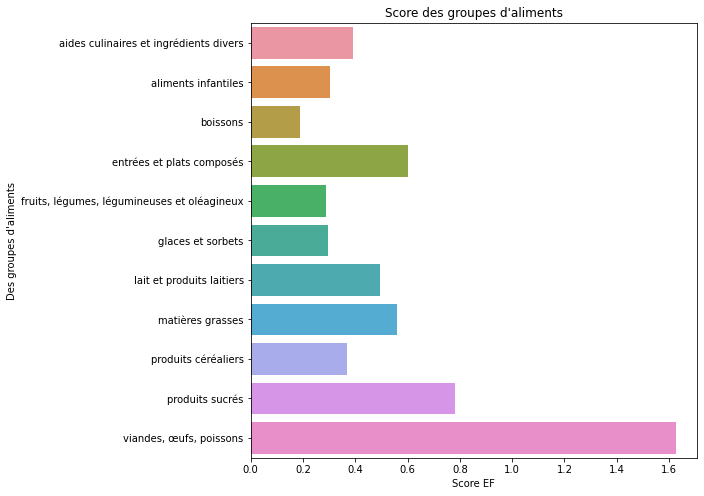

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Score des groupes d'aliments")

sns.barplot(y=df_agr_score.Group_aliment, x = df_agr_score.Score_EF, data = df_agr_score)

plt.ylabel("Des groupes d'aliments")
plt.xlabel("Score EF");

Calculons maintenant l'impact par personne qui mange tous les aliments eт un an.

In [ ]:
df_par_an

,Catégorie de produit,Un adulte (kg/par an)
0,Produits laitiers,63.510
1,Fruits et légumes,169.360
2,"Viandes, poissons, œufs",63.510
3,Produits céréales,63.510
4,Eaux et autres boissons,582.175
5,Autres,116.435


In [ ]:
df_agr_score

,Group_aliment,Score_EF
0,aides culinaires et ingrédients divers,0.389715
1,aliments infantiles,0.304532
2,boissons,0.187846
3,entrées et plats composés,0.601687
4,"fruits, légumes, légumineuses et oléagineux",0.287862
5,glaces et sorbets,0.295183
6,lait et produits laitiers,0.495994
7,matières grasses,0.561052
8,produits céréaliers,0.369015
9,produits sucrés,0.783399


Score des Produits laitiers = 63.510 * 0.495663 = 31,47955713. Score des Fruits et légumes= 169.360 * 0.287862 = 48,75230832. Score des boisson = 0.187846 * 582.175 = 109,35924505. Score des Viandes, poissons, œufs = 63.510 * 1.626342 = 103,28898042. Score des Produits céréales = 63.510 * 0.369015 = 23,43614265. Score des Autres = 116.435 * ((0.389715 + 0.295183 + 0.561052 + 0.783399)/4) = 59,07181270375.

In [ ]:
my_dict2 = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            'Score_par_an' : [31.47955713, 48.75230832, 103.28898042, 23.43614265, 109.35924505, 59.07181270375]}

df_agr_score_par_an = pd.DataFrame(my_dict2)
df_agr_score_par_an

,Catégorie de produit,Score_par_an
0,Produits laitiers,31.479557
1,Fruits et légumes,48.752308
2,"Viandes, poissons, œufs",103.288980
3,Produits céréales,23.436143
4,Eaux et autres boissons,109.359245
5,Autres,59.071813


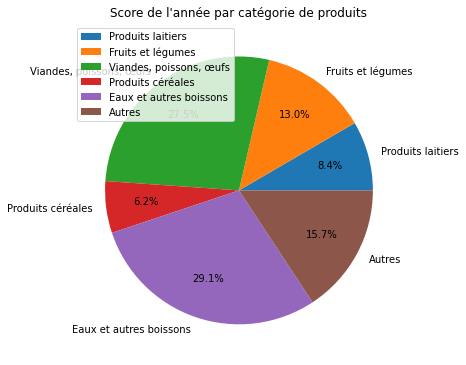

In [ ]:
plt.figure(figsize = (6,8))

plt.title("Score de l'année par catégorie de produits")

plt.pie(df_agr_score_par_an['Score_par_an'], labels=df_agr_score_par_an['Catégorie de produit'].values, 
        autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_agr_score_par_an.Score_par_an.mean()
print("Pour toutes les catégories d'aliments, le score moyen pour l'année est", df_agr_score_par_an.Score_par_an.mean())

Pour toutes les catégories d'aliments, le score moyen pour l'année est 62.56467437895833


Considérez le score moyen pour une année de végétarisme. Le végétarisme est un régime alimentaire à base de plantes et de produits laitiers, avec le rejet de la viande et des aliments d'origine animale (y compris la volaille, le poisson et les fruits de mer). Certaines options végétariennes peuvent exclure les produits laitiers et les œufs. Mais dans mon analyse, je quitterai ce dernier. Remplaçons la viande et le poisson dans une assiette de Français par des légumes, des fruits et des légumineuses.

In [ ]:
my_dict = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            
           'Un végétarien (%)': [6,20,2,6,55,11]}

df_végét= pd.DataFrame(my_dict)
df_végét

,Catégorie de produit,Un végétarien (%)
0,Produits laitiers,6
1,Fruits et légumes,20
2,œufs,2
3,Produits céréales,6
4,Eaux et autres boissons,55
5,Autres,11


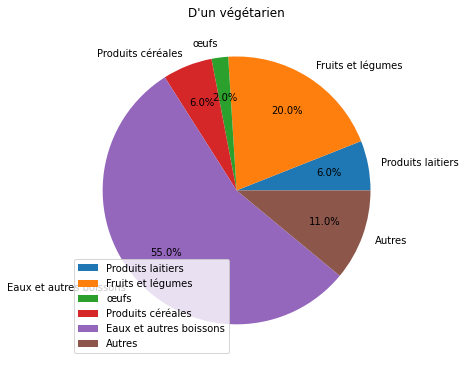

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un végétarien")

plt.pie(df_végét['Un végétarien (%)'], labels=df_végét['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

Nous excluons les produits animaux de notre base de données d'origine et calculons le score.

In [ ]:
# Examinons en détail les sous-groupes d'aliments et excluons les aliments qui ne sont pas consommés par les végétariens.
df_agr.Sous_group_aliment.unique()

array(['fromages', 'fruits',
       'produits à base de poissons et produits de la mer', 'algues',
       'viandes cuites', 'viandes crues', 'herbes', 'boisson alcoolisées',
       'plats composés', 'fruits à coque et graines oléagineuses',
       'pâtes, riz et céréales', 'farines et pâtes à tarte',
       'poissons crus', 'charcuteries', 'légumes',
       'gâteaux et pâtisseries', 'pains et viennoiseries',
       'pommes de terre et autres tubercules', 'poissons cuits',
       'chocolats et produits à base de chocolat',
       'céréales de petit-déjeuner et biscuits', 'glaces',
       'ingrédients divers', 'feuilletées et autres entrées', 'beurres',
       'huiles et graisses végétales', 'céréales et biscuits infantiles',
       'autres produits à base de viande', 'boissons sans alcool',
       'laits et boissons infantiles',
       'produits laitiers frais et assimilés',
       'confiseries non chocolatées', 'soupes', 'desserts glacés',
       'sandwichs', 'pizzas, tartes et crêpes 

In [ ]:
df_agr_végét = df_agr[(df_agr.Sous_group_aliment == 'fruits')| (df_agr.Sous_group_aliment == 'algues')|
                  (df_agr.Sous_group_aliment == 'herbes')|(df_agr.Sous_group_aliment == 'boisson alcoolisées')|
                  (df_agr.Sous_group_aliment == 'fruits à coque et graines oléagineuses')|
                  (df_agr.Sous_group_aliment == 'pâtes, riz et céréales')|
                  (df_agr.Sous_group_aliment == 'farines et pâtes à tarte')|
                  (df_agr.Sous_group_aliment == 'légumes')|
                  (df_agr.Sous_group_aliment == 'fromages')|
                  (df_agr.Sous_group_aliment == 'gâteaux et pâtisseries')|
                  (df_agr.Sous_group_aliment == 'pains et viennoiseries')|
                  (df_agr.Sous_group_aliment == 'pommes de terre et autres tubercules')|
                  (df_agr.Sous_group_aliment == 'chocolats et produits à base de chocolat')|
                  (df_agr.Sous_group_aliment == 'céréales de petit-déjeuner et biscuits')|
                  (df_agr.Sous_group_aliment == 'ingrédients divers')|
                  (df_agr.Sous_group_aliment == 'beurres')|
                  (df_agr.Sous_group_aliment == 'glaces')| (df_agr.Sous_group_aliment == 'huiles et graisses végétales')|
                  (df_agr.Sous_group_aliment == 'boissons sans alcool')|
                  (df_agr.Sous_group_aliment == 'produits laitiers frais et assimilés')|
                  (df_agr.Sous_group_aliment == 'épices')|
                  (df_agr.Sous_group_aliment == 'sauces')|
                  (df_agr.Sous_group_aliment == 'confiseries non chocolatées')|
                  (df_agr.Sous_group_aliment == 'confitures et assimilés')|(df_agr.Sous_group_aliment == 'desserts glacés')|
                  (df_agr.Sous_group_aliment == 'aides culinaires')|(df_agr.Sous_group_aliment == 'eaux')|
                  (df_agr.Sous_group_aliment == 'crèmes et spécialités à base de crème')|
                  (df_agr.Sous_group_aliment == 'légumineuses')|
                  (df_agr.Sous_group_aliment == 'sucres, miels et assimilés')|
                  (df_agr.Sous_group_aliment == 'sels')|(df_agr.Sous_group_aliment == 'sorbets')|
                  (df_agr.Sous_group_aliment == 'laits')|
                  (df_agr.Sous_group_aliment == 'autres matières grasses')|
                  (df_agr.Sous_group_aliment == 'margarines')|(df_agr.Sous_group_aliment == 'condiments')|
                  (df_agr.Sous_group_aliment == 'œufs')|
                  (df_agr.Sous_group_aliment == 'denrées destinées à une alimentation particulière')
               ]
df_agr_végét.head(2)

,Code_AGB,Code_CIQUAL,Group_aliment,Sous_group_aliment,Nom_produit,LCI,saisonnalite,usage_avion,Mode_Livraison,Type_emballage,Mode_Preparation,DQR,Score_EF,Change_clima,impact_ozone,rayons_ionisants,photochimique_ozone,particules,acidification,Eutrophisation_terre,Eutrophisation_eau_douce,Eutrophisation_eau_marine,usage_sol,ecotoxicite,epuisement_eau,epuisement_energie,epuisement_mineraux
0,12112,12112,lait et produits laitiers,fromages,Abondance,"Abondance cheese, from cow's milk",mix de consommation FR,0,Glacé,LPDE,Pas de préparation,2.24,0.568767,6.265706,0.294111,0.749790,10.559496,0.460604,0.063562,0.270609,0.758147,19.195108,307.324710,87.412574,2.180830,34.659384,4.694938
1,13712,13712,"fruits, légumes, légumineuses et oléagineux",fruits,"Abricot au sirop léger, appertisé, égoutté","Apricot, canned in light syrup, drained",mix de consommation FR,0,Ambiant (moyenne),Acier,Pas de préparation,2.46,0.215366,1.221121,0.248176,1.820853,4.658415,0.096413,0.009301,0.031766,0.410555,1.502775,44.823181,62.195218,1.630637,47.237697,2.938064


In [ ]:
# Calculons le score de la base de données reçue
df_agr_végét_score = df_agr_végét.groupby("Group_aliment", as_index = False).agg({"Score_EF" : "mean"})
df_agr_végét_score.sort_values(["Score_EF"], ascending = False)

,Group_aliment,Score_EF
7,produits sucrés,0.783399
5,matières grasses,0.590871
8,"viandes, œufs, poissons",0.570287
4,lait et produits laitiers,0.495994
0,aides culinaires et ingrédients divers,0.389715
6,produits céréaliers,0.369015
3,glaces et sorbets,0.295183
2,"fruits, légumes, légumineuses et oléagineux",0.287862
1,boissons,0.187846


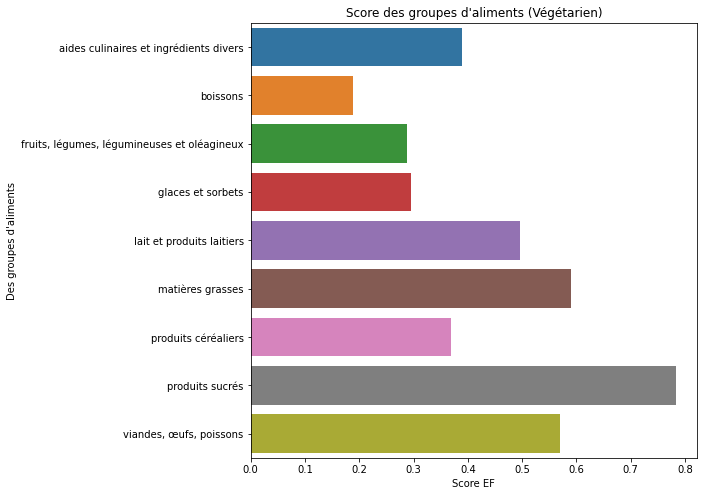

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Score des groupes d'aliments (Végétarien)")

sns.barplot(y=df_agr_végét_score.Group_aliment, x = df_agr_végét_score.Score_EF, data = df_agr_végét_score)

plt.ylabel("Des groupes d'aliments")
plt.xlabel("Score EF");

In [ ]:
# Calculons le score de l'année par catégorie de produits (Végétarien).
df_végét
a = pd.DataFrame(df_végét['Catégorie de produit'])
b = pd.DataFrame((df_végét['Un végétarien (%)']*1058.5)/100)
dictionary = ({"Un végétarien (%)" :"Un végétarien (kg/par an)"})
b.rename(columns = dictionary , inplace=True)
df_végét_par_an = pd.concat([a, b],  axis=1)

df_végét_par_an

,Catégorie de produit,Un végétarien (kg/par an)
0,Produits laitiers,63.510
1,Fruits et légumes,211.700
2,œufs,21.170
3,Produits céréales,63.510
4,Eaux et autres boissons,582.175
5,Autres,116.435


Score des Produits laitiers = 63.510 * 0.495663 = 31,47955713. Score des Fruits et légumes= 211.700 * 0.287862 = 60,9403854. Score des boisson = 0.187846 * 582.175 = 109,35924505. Score des Viandes, poissons, œufs = 21.170 * 0.570287 = 12,07297579. Score des Produits céréales = 63.510 * 0.369015 = 23,43614265. Score des Autres = 116.435 * ((0.389715 + 0.295183 + 0.590871 + 0.783399)/4) = 59,93980652.

In [ ]:
my_dict3 = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            'Score_par_an' : [31.47955713, 60.9403854, 12.07297579, 23.43614265, 109.35924505, 59.93980652]}

df_végét_score_par_an = pd.DataFrame(my_dict3)
df_végét_score_par_an

,Catégorie de produit,Score_par_an
0,Produits laitiers,31.479557
1,Fruits et légumes,60.940385
2,"Viandes, poissons, œufs",12.072976
3,Produits céréales,23.436143
4,Eaux et autres boissons,109.359245
5,Autres,59.939807


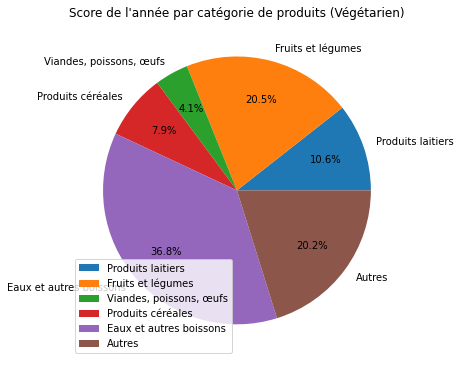

In [ ]:
plt.figure(figsize = (6,8))

plt.title("Score de l'année par catégorie de produits (Végétarien)")

plt.pie(df_végét_score_par_an['Score_par_an'], labels=df_végét_score_par_an['Catégorie de produit'].values, 
        autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_végét_score_par_an.Score_par_an.mean()
print("Pour les végétariens, le score moyen pour l'année est", df_végét_score_par_an.Score_par_an.mean())

Pour les végétariens, le score moyen pour l'année est 49.538018756666666


Considérez le score moyen pour une année végétalienne. Les végétaliens refusent de consommer tous les types de viande, le lait (à l'exclusion du lait maternel lorsqu'ils nourrissent les bébés), les œufs, le miel, ainsi que d'autres substances et additifs produits à partir d'animaux (comme la gélatine ou le carmin).

In [ ]:
my_dict = {'Catégorie de produit' : ["Fruits et légumes", "Produits céréales", "Viandes, poissons, œufs", "Produits laitiers",
                                     "Eaux et autres boissons","Autres"],
            
           'Un végétalienne (%)': [28, 6, 0, 0, 55, 11]}

df_végan= pd.DataFrame(my_dict)
df_végan

,Catégorie de produit,Un végétalienne (%)
0,Fruits et légumes,28
1,Produits céréales,6
2,"Viandes, poissons, œufs",0
3,Produits laitiers,0
4,Eaux et autres boissons,55
5,Autres,11


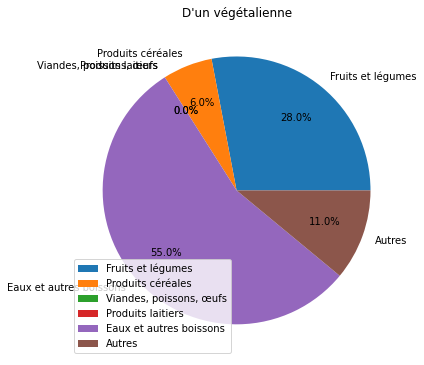

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un végétalienne")

plt.pie(df_végan['Un végétalienne (%)'], labels=df_végan['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

Modifions notre base de données en fonction de la culture végétalienne.

In [ ]:
# Je ne laisse dans la base de données que les catégories de produits qui ne font aucun doute
df_agr_végan = df_agr[(df_agr.Sous_group_aliment == 'fruits')| (df_agr.Sous_group_aliment == 'algues')|
                  (df_agr.Sous_group_aliment == 'herbes')|(df_agr.Sous_group_aliment == 'boisson alcoolisées')|
                  (df_agr.Sous_group_aliment == 'fruits à coque et graines oléagineuses')|
                  (df_agr.Sous_group_aliment == 'pâtes, riz et céréales')|
                  (df_agr.Sous_group_aliment == 'légumes')|
                  (df_agr.Sous_group_aliment == 'pommes de terre et autres tubercules')|
                  (df_agr.Sous_group_aliment == 'huiles et graisses végétales')|
                  (df_agr.Sous_group_aliment == 'boissons sans alcool')|
                  (df_agr.Sous_group_aliment == 'épices')|
                  (df_agr.Sous_group_aliment == 'confitures et assimilés')|
                  (df_agr.Sous_group_aliment == 'eaux')|
                  (df_agr.Sous_group_aliment == 'légumineuses')|
                  (df_agr.Sous_group_aliment == 'sels')|(df_agr.Sous_group_aliment == 'sorbets')|
                  (df_agr.Sous_group_aliment == 'condiments')]
df_agr_végan.head(2)

,Code_AGB,Code_CIQUAL,Group_aliment,Sous_group_aliment,Nom_produit,LCI,saisonnalite,usage_avion,Mode_Livraison,Type_emballage,Mode_Preparation,DQR,Score_EF,Change_clima,impact_ozone,rayons_ionisants,photochimique_ozone,particules,acidification,Eutrophisation_terre,Eutrophisation_eau_douce,Eutrophisation_eau_marine,usage_sol,ecotoxicite,epuisement_eau,epuisement_energie,epuisement_mineraux
1,13712,13712,"fruits, légumes, légumineuses et oléagineux",fruits,"Abricot au sirop léger, appertisé, égoutté","Apricot, canned in light syrup, drained",mix de consommation FR,0,Ambiant (moyenne),Acier,Pas de préparation,2.46,0.215366,1.221121,0.248176,1.820853,4.658415,0.096413,0.009301,0.031766,0.410555,1.502775,44.823181,62.195218,1.630637,47.237697,2.938064
2,13713,13713,"fruits, légumes, légumineuses et oléagineux",fruits,"Abricot au sirop léger, appertisé, non égoutté","Apricot, canned in light syrup, not drained",mix de consommation FR,0,Ambiant (moyenne),Acier,Pas de préparation,2.46,0.128043,0.612234,0.153879,1.135915,2.784663,0.059314,0.005726,0.019499,0.235366,0.797791,27.901738,36.285914,1.010960,29.397697,1.823726


In [ ]:
# Examiner et ajuster les groupes de sous-aliments qui sont discutables pour la consommation végétalienne
df_agr.Nom_produit[(df_agr.Sous_group_aliment == 'farines et pâtes à tarte')].unique()

array(['Amidon de maïs ou fécule de maïs',
       'Farine de blé tendre ou froment avec levure incorporée',
       'Farine de blé tendre ou froment T110',
       'Farine de blé tendre ou froment T150',
       'Farine de blé tendre ou froment T45 (pour pâtisserie)',
       'Farine de blé tendre ou froment T55 (pour pains)',
       'Farine de blé tendre ou froment T65',
       'Farine de blé tendre ou froment T80', 'Farine de maïs',
       'Farine de millet', 'Farine de pois chiche', 'Farine de riz',
       'Farine de sarrasin', 'Farine de seigle T130',
       'Farine de seigle T170', 'Farine de seigle T85', 'Farine de soja',
       "Farine d'épeautre (grand épeautre)", "Farine d'orge",
       "Flocon d'avoine", 'Khatfa feuille de brick, préemballée',
       'Pâte à pizza crue', 'Pâte à pizza cuite',
       'Pâte à pizza fine, crue', 'Pâte brisée, crue',
       'Pâte brisée, matière grasse végétale, cuite',
       'Pâte brisée, pur beurre, crue',
       'Pâte brisée, pur beurre, surgelée

In [ ]:
a = df_agr[(df_agr.Nom_produit == 'Farine de blé tendre ou froment avec levure incorporée')| 
            (df_agr.Nom_produit == 'Amidon de maïs ou fécule de maïs')|
            (df_agr.Nom_produit == 'Farine de blé tendre ou froment T110')|
            (df_agr.Nom_produit == 'Farine de blé tendre ou froment T150')|
            (df_agr.Nom_produit == 'Farine de blé tendre ou froment T45 (pour pâtisserie)')|
            (df_agr.Nom_produit == 'Farine de blé tendre ou froment T55 (pour pains)')|
            (df_agr.Nom_produit == 'Farine de blé tendre ou froment T65')|
            (df_agr.Nom_produit == 'Farine de blé tendre ou froment T80')|
            (df_agr.Nom_produit == 'Farine de maïs')|
            (df_agr.Nom_produit == 'Farine de millet')|
            (df_agr.Nom_produit == 'Farine de pois chiche')|
            (df_agr.Nom_produit == 'Farine de riz')|
            (df_agr.Nom_produit == 'Farine de sarrasin')|
            (df_agr.Nom_produit == 'Farine de seigle T130')|
            (df_agr.Nom_produit == 'Farine de seigle T170')|
            (df_agr.Nom_produit == 'Farine de seigle T85')|
            (df_agr.Nom_produit == 'Farine de soja')|
            (df_agr.Nom_produit == "Farine d'épeautre (grand épeautre)")|
            (df_agr.Nom_produit == "Farine d'orge")|
            (df_agr.Nom_produit == "Flocon d'avoine")|
            (df_agr.Nom_produit == 'Khatfa feuille de brick, préemballée')]

In [ ]:
df_agr.Nom_produit[(df_agr.Sous_group_aliment == 'céréales de petit-déjeuner et biscuits')].unique()

array(['Barre biscuitée fourrée aux fruits, allégée en matière grasse',
       'Barre céréalière "équilibre" aux fruits, enrichie en vitamines et minéraux',
       'Barre céréalière "équilibre" chocolatée, enrichie en vitamines et minéraux',
       'Barre céréalière aux amandes ou noisettes',
       'Barre céréalière aux fruits', 'Barre céréalière chocolatée',
       'Barre céréalière pour petit déjeuner au lait, chocolatée ou non, enrichie en vitamines et minéraux',
       'Biscuit apéritif à base de pomme de terre, type tuile salée',
       'Biscuit apéritif feuilleté',
       'Biscuit apéritif soufflé, à base de maïs, à la cacahuète',
       'Biscuit apéritif soufflé, à base de maïs, sans cacahuète',
       'Biscuit apéritif soufflé, à base de pomme de terre',
       'Biscuit apéritif soufflé, à base de pomme de terre et de soja',
       'Biscuit apéritif, crackers, garni ou fourré, au fromage',
       'Biscuit apéritif, crackers, nature',
       'Biscuit apéritif, crackers, nature,

In [ ]:
b = df_agr[(df_agr.Nom_produit == 'Barre céréalière "équilibre" aux fruits, enrichie en vitamines et minéraux')| 
            (df_agr.Nom_produit == 'Barre céréalière aux amandes ou noisettes')|
            (df_agr.Nom_produit == 'Barre céréalière aux fruits')|
            (df_agr.Nom_produit == 'Céréales complètes soufflées, enrichies en vitamines et minéraux')|
            (df_agr.Nom_produit == 'Céréales pour petit déjeuner "équilibre" aux fruits (non enrichies en vitamines et minéraux)')|
            (df_agr.Nom_produit == 'Céréales pour petit déjeuner "équilibre" aux fruits secs (à coque), enrichis en vitamines et minéraux')|
            (df_agr.Nom_produit == 'Céréales pour petit déjeuner "équilibre" aux fruits, enrichies en vitamines et minéraux')|
            (df_agr.Nom_produit == 'Céréales pour petit déjeuner "équilibre" nature (non enrichies en vitamines et minéraux)')|
            (df_agr.Nom_produit == 'Céréales pour petit déjeuner riches en fibres, avec ou sans fruits, enrichies en vitamines et minéraux')|
            (df_agr.Nom_produit == 'Céréales pour petit déjeuner très riches en fibres, enrichies en vitamines et minéraux')|
            (df_agr.Nom_produit == "Flocon d'avoine précuit")|
            (df_agr.Nom_produit == "Flocons d'avoine, bouillis/cuits à l'eau")|
            (df_agr.Nom_produit == 'Muesli croustillant aux fruits et/ou fruits secs, graines (non enrichi en vitamines et minéraux)')|
            (df_agr.Nom_produit == 'Multi-céréales soufflées ou extrudées, enrichies en vitamines et minéraux')|
            (df_agr.Nom_produit == "Pop-corn ou Maïs éclaté, à l'air, non salé")|
            (df_agr.Nom_produit == "Pop-corn ou Maïs éclaté, à l'huile, salé")|
            (df_agr.Nom_produit == 'Pop-corn ou Maïs éclaté, au caramel')|
            (df_agr.Nom_produit == 'Sablé à la noix de coco')|
            (df_agr.Nom_produit == "Muesli croustillant aux fruits ou fruits secs, enrichi en vitamines et minéraux")|
            (df_agr.Nom_produit == "Muesli floconneux aux fruits ou fruits secs (non enrichi en vitamines et minéraux)")|
            (df_agr.Nom_produit == "Muesli floconneux aux fruits ou fruits secs, enrichi en vitamines et minéraux")|
            (df_agr.Nom_produit == 'Muesli floconneux aux fruits ou fruits secs, sans sucres ajoutés')|
            (df_agr.Nom_produit == 'Muesli floconneux ou de type traditionnel')]

In [ ]:
df_agr.Nom_produit[(df_agr.Sous_group_aliment == 'ingrédients divers')].unique()

array(['Base de pizza à la crème', 'Base de pizza tomatée',
       'Bicarbonate de soude', 'Gélatine, sèche', 'Lécithine de soja',
       'Levure alimentaire', 'Levure chimique ou Poudre à lever',
       'Levure de boulanger, compressée',
       'Levure de boulanger, déshydratée', 'Miso',
       'Sirop léger pour fruits appertisés au sirop',
       'Sirop pour fruits appertisés au sirop', "Son d'avoine",
       'Son de blé', 'Son de maïs', 'Son de riz', 'Tempeh'], dtype=object)

In [ ]:
c = df_agr[(df_agr.Nom_produit == 'Bicarbonate de soude')|
            (df_agr.Nom_produit == 'Lécithine de soja')|
            (df_agr.Nom_produit == 'Levure alimentaire')|
            (df_agr.Nom_produit == 'Levure chimique ou Poudre à lever')|
            (df_agr.Nom_produit == 'Levure de boulanger, compressée')|
            (df_agr.Nom_produit == 'Levure de boulanger, déshydratée')|
            (df_agr.Nom_produit == 'Miso')|
            (df_agr.Nom_produit == 'Sirop léger pour fruits appertisés au sirop')|
            (df_agr.Nom_produit == 'Sirop pour fruits appertisés au sirop')|
            (df_agr.Nom_produit == "Son d'avoine")|
            (df_agr.Nom_produit == 'Son de blé')|
            (df_agr.Nom_produit == 'Son de maïs')|
            (df_agr.Nom_produit == 'Son de riz')]         

In [ ]:
df_agr.Nom_produit[(df_agr.Sous_group_aliment == 'aides culinaires')].unique()

array(['Court-bouillon pour poissons, déshydraté',
       'Pizza, sauce garniture pour',
       'Préparation culinaire à base de soja, type "crème de soja"'],
      dtype=object)

In [ ]:
d = df_agr[(df_agr.Nom_produit == 'Préparation culinaire à base de soja, type "crème de soja')|
           (df_agr.Nom_produit == "Pizza, sauce garniture pour")]

In [ ]:
df_agr.Nom_produit[(df_agr.Sous_group_aliment == 'sucres, miels et assimilés')].unique()

array(['Édulcorant à la saccharine', 'Fructose', 'Mélasse de canne',
       'Miel', 'Sucre blanc', 'Sucre roux', 'Sucre vanillé'], dtype=object)

In [ ]:
e = df_agr[(df_agr.Nom_produit == 'Édulcorant à la saccharine')|(df_agr.Nom_produit == "Fructose")|
           (df_agr.Nom_produit == 'Mélasse de canne')|(df_agr.Nom_produit == 'Sucre blanc')|
           (df_agr.Nom_produit == 'Sucre roux')|(df_agr.Nom_produit == 'Sucre vanillé')]

In [ ]:
df_agr_végan = pd.concat([df_agr_végan,a,b,c,d,e], axis=0)

In [ ]:
# Calculons le score de la base de données reçue
df_agr_végan_score = df_agr_végan.groupby("Group_aliment", as_index = False).agg({"Score_EF" : "mean"})
df_agr_végan_score.sort_values(["Score_EF"], ascending = False)

,Group_aliment,Score_EF
4,matières grasses,0.649879
0,aides culinaires et ingrédients divers,0.378420
3,glaces et sorbets,0.373484
6,produits sucrés,0.301741
2,"fruits, légumes, légumineuses et oléagineux",0.287862
5,produits céréaliers,0.263838
1,boissons,0.187846


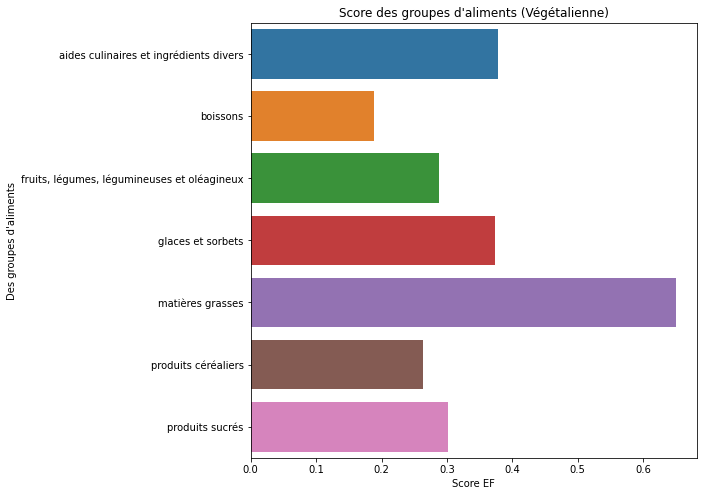

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Score des groupes d'aliments (Végétalienne)")

sns.barplot(y=df_agr_végan_score.Group_aliment, x = df_agr_végan_score.Score_EF, data = df_agr_végan_score)

plt.ylabel("Des groupes d'aliments")
plt.xlabel("Score EF");

In [ ]:
# Calculons le score de l'année par catégorie de produits (Végétarien).

a = pd.DataFrame(df_végan['Catégorie de produit'])
b = pd.DataFrame((df_végan['Un végétalienne (%)']*1058.5)/100)
dictionary = ({"Un végétalienne (%)" :"Un végétalienne (kg/par an)"})
b.rename(columns = dictionary , inplace=True)
df_végan_par_an = pd.concat([a, b],  axis=1)

df_végan_par_an

,Catégorie de produit,Un végétalienne (kg/par an)
0,Fruits et légumes,296.380
1,Produits céréales,63.510
2,"Viandes, poissons, œufs",0.000
3,Produits laitiers,0.000
4,Eaux et autres boissons,582.175
5,Autres,116.435


Score des Fruits et légumes= 296.380 * 0.287862 = 85,31653956. Score des boisson = 0.187846 * 582.175 = 109,35924505. Score des Produits céréales = 63.510 * 0.263838 = 16,75635138. Score des Autres = 116.435 * ((0.649879 + 0.378420 + 0.373484 + 0.301741)/4) = 49,587454235.

In [ ]:
my_dict3 = {'Catégorie de produit' : ["Fruits et légumes", "Produits céréales", 'Viandes, poissons, œufs', 'Produits laitiers', 
                                     "Eaux et autres boissons","Autres"],
            'Score_par_an' : [85.31653956, 16.75635138, 0, 0,109.35924505, 49.587454235]}

df_végan_score_par_an = pd.DataFrame(my_dict3)
df_végan_score_par_an

,Catégorie de produit,Score_par_an
0,Fruits et légumes,85.316540
1,Produits céréales,16.756351
2,"Viandes, poissons, œufs",0.000000
3,Produits laitiers,0.000000
4,Eaux et autres boissons,109.359245
5,Autres,49.587454


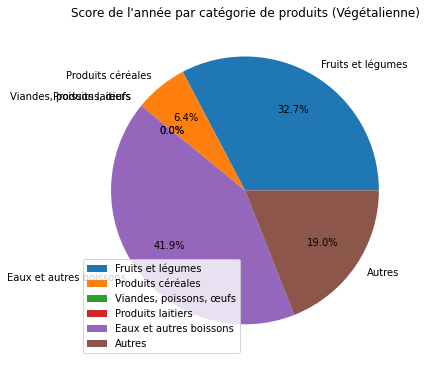

In [ ]:
plt.figure(figsize = (6,8))

plt.title("Score de l'année par catégorie de produits (Végétalienne)")

plt.pie(df_végan_score_par_an['Score_par_an'], labels=df_végan_score_par_an['Catégorie de produit'].values, 
        autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_végan_score_par_an.Score_par_an.mean()
print("Pour les végétaliens, le score moyen pour l'année est", df_végan_score_par_an.Score_par_an.mean())

Pour les végétaliens, le score moyen pour l'année est 43.5032650375


Considérez le type d'aliment suivant "flexitarisme". Le flexitarisme est un régime à prédominance végétale qui permet la consommation de chair animale pour se nourrir. Les flexitariens s'efforcent de consommer le moins de viande possible, mais en même temps ils ne l'excluent pas complètement de leur alimentation. Dans le même temps, il n'y a pas de quantité spécifique de viande consommée pour la classification flexitarienne. Nous laissons les œufs dans l'assiette du flexitarien et autorisons une quantité minimale de nourriture d'origine animale.

In [ ]:
my_dict = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            
           'Un flexitarienne (%)': [6,19,3,6,55,11]}

df_flex= pd.DataFrame(my_dict)
df_flex

,Catégorie de produit,Un flexitarienne (%)
0,Produits laitiers,6
1,Fruits et légumes,19
2,"Viandes, poissons, œufs",3
3,Produits céréales,6
4,Eaux et autres boissons,55
5,Autres,11


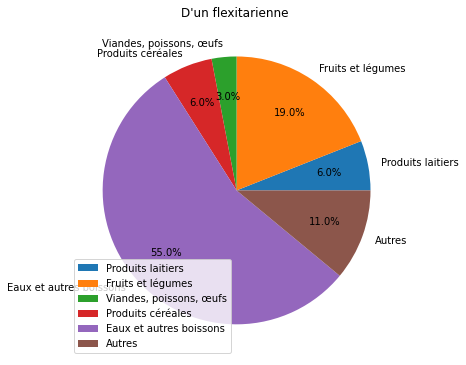

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un flexitarienne ")

plt.pie(df_flex['Un flexitarienne (%)'], labels=df_flex['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
a = pd.DataFrame(df_flex['Catégorie de produit'])
b = pd.DataFrame((df_flex['Un flexitarienne (%)']*1058.5)/100)
dictionary = ({"Un flexitarienne (%)" :"Un flexitarienne (kg/par an)"})
b.rename(columns = dictionary , inplace=True)
df_flex_par_an = pd.concat([a, b],  axis=1)

df_flex_par_an 

,Catégorie de produit,Un flexitarienne (kg/par an)
0,Produits laitiers,63.510
1,Fruits et légumes,201.115
2,"Viandes, poissons, œufs",31.755
3,Produits céréales,63.510
4,Eaux et autres boissons,582.175
5,Autres,116.435


In [ ]:
df_agr_score = df_agr.groupby("Group_aliment", as_index = False).agg({"Score_EF" : "mean"})
df_agr_score.sort_values(["Score_EF"], ascending = False)

,Group_aliment,Score_EF
10,"viandes, œufs, poissons",1.626342
9,produits sucrés,0.783399
3,entrées et plats composés,0.601687
7,matières grasses,0.561052
6,lait et produits laitiers,0.495994
0,aides culinaires et ingrédients divers,0.389715
8,produits céréaliers,0.369015
1,aliments infantiles,0.304532
5,glaces et sorbets,0.295183
4,"fruits, légumes, légumineuses et oléagineux",0.287862


Score des Produits laitiers = 63.510 * 0.495663 = 31,47955713. Score des Fruits et légumes= 201.115 * 0.287862 = 57,89336613. Score des boisson = 0.187846 * 582.175 = 109,35924505. Score des Viandes, poissons, œufs = 31.755 * 1.626342 = 51,64449021. Score des Produits céréales = 63.510 * 0.369015 = 23,43614265. Score des Autres = 116.435 * ((0.389715 + 0.295183 + 0.561052 + 0.783399)/4) = 59,07181270375.

In [ ]:
my_dict3 = {'Catégorie de produit' : ["Fruits et légumes", "Produits céréales", 'Viandes, poissons, œufs', 'Produits laitiers', 
                                     "Eaux et autres boissons","Autres"],
            'Score_par_an' : [57.89336613, 23.43614265, 51.64449021, 31.47955713,109.35924505, 59.07181270375]}

df_flex_score_par_an = pd.DataFrame(my_dict3)
df_flex_score_par_an

,Catégorie de produit,Score_par_an
0,Fruits et légumes,57.893366
1,Produits céréales,23.436143
2,"Viandes, poissons, œufs",51.644490
3,Produits laitiers,31.479557
4,Eaux et autres boissons,109.359245
5,Autres,59.071813


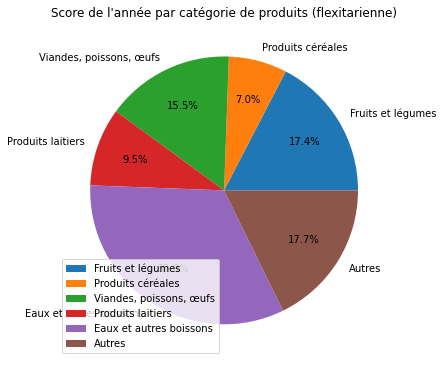

In [ ]:
plt.figure(figsize = (6,8))

plt.title("Score de l'année par catégorie de produits (flexitarienne)")

plt.pie(df_flex_score_par_an['Score_par_an'], labels=df_flex_score_par_an['Catégorie de produit'].values, 
        autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_flex_score_par_an.Score_par_an.mean()
print("Pour le flexitarisme, le score moyen pour l'année est", df_flex_score_par_an.Score_par_an.mean())

Pour le flexitarisme, le score moyen pour l'année est 55.48076897895832


Le régime paléolithique (régime paléolithique, régime de l'âge de pierre, régime des chasseurs-cueilleurs) est une approche moderne de la nutrition, consistant principalement en la consommation d'aliments d'origine végétale et animale, et est basé sur l'ancien régime alimentaire supposé des gens au cours du Paléolithique - un période de 2,5 millions d'années s'est terminée il y a 10 mille ans. Le régime paléolithique moderne se compose d'aliments disponibles aujourd'hui et comprend du poisson, de la viande et de la volaille, de préférence nourris à l'herbe, des légumes, des fruits, des rhizomes et des noix. Cependant, il exclut les céréales, les produits laitiers, les légumineuses, le sucre et les huiles transformées.

In [ ]:
my_dict = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            
           'Un paleo (%)': [0,22,12,0,55,11]}

df_paleo= pd.DataFrame(my_dict)
df_paleo

,Catégorie de produit,Un paleo (%)
0,Produits laitiers,0
1,Fruits et légumes,22
2,"Viandes, poissons, œufs",12
3,Produits céréales,0
4,Eaux et autres boissons,55
5,Autres,11


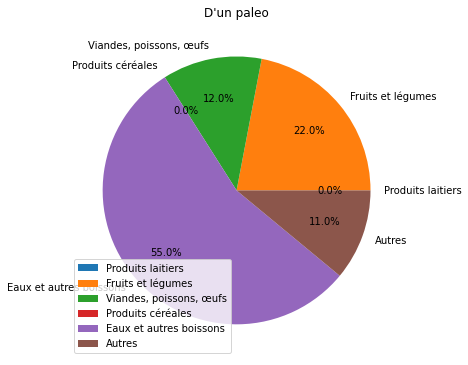

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un paleo")

plt.pie(df_paleo['Un paleo (%)'], labels=df_paleo['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_agr_paleo = df_agr[(df_agr.Group_aliment == 'fruits, légumes, légumineuses et oléagineux')| 
                (df_agr.Group_aliment == 'viandes, œufs, poissons')| (df_agr.Group_aliment == 'boissons')|
                (df_agr.Group_aliment == 'matières grasses')]

In [ ]:
df_agr_paleo.Sous_group_aliment.unique()

array(['fruits', 'produits à base de poissons et produits de la mer',
       'viandes cuites', 'viandes crues', 'boisson alcoolisées',
       'fruits à coque et graines oléagineuses', 'poissons crus',
       'charcuteries', 'légumes', 'pommes de terre et autres tubercules',
       'poissons cuits', 'beurres', 'huiles et graisses végétales',
       'autres produits à base de viande', 'boissons sans alcool',
       'mollusques et crustacés cuits', 'mollusques et crustacés crus',
       'eaux', 'légumineuses', 'autres matières grasses',
       'huiles de poissons', 'margarines', 'œufs'], dtype=object)

In [ ]:
df_agr_paleo = df_agr_paleo[(df_agr_paleo.Sous_group_aliment == 'fruits')| 
                  (df_agr_paleo.Sous_group_aliment == 'produits à base de poissons et produits de la mer')|
                  (df_agr_paleo.Sous_group_aliment == 'viandes crues')|
                  (df_agr_paleo.Sous_group_aliment == 'fruits à coque et graines oléagineuses')|
                  (df_agr_paleo.Sous_group_aliment == 'poissons crus')|
                  (df_agr_paleo.Sous_group_aliment == 'viandes cuites')|
                  (df_agr_paleo.Sous_group_aliment == 'poissons cuits')|
                  (df_agr_paleo.Sous_group_aliment == 'autres produits à base de viande')|
                  (df_agr_paleo.Sous_group_aliment == 'mollusques et crustacés cuits')|
                  (df_agr_paleo.Sous_group_aliment == 'mollusques et crustacés crus')|
                  (df_agr_paleo.Sous_group_aliment == 'eaux')| 
                  (df_agr_paleo.Sous_group_aliment == 'autres matières grasses')| 
                  (df_agr_paleo.Sous_group_aliment == 'huiles de poissons')| 
                  (df_agr_paleo.Sous_group_aliment == 'œufs')]

In [ ]:
a = df_agr[(df_agr.Nom_produit == "Beurre de cacao")|
             (df_agr.Nom_produit == "Huile d'olive vierge extra")|
             (df_agr.Nom_produit == "Huile d'olive vierge extra")|
             (df_agr.Nom_produit == "Huile de noisette")]
df_agr_paleo = pd.concat([df_agr_paleo,a], axis=0)

In [ ]:
# Calculons le score de la base de données reçue
df_agr_paleo_score = df_agr_paleo.groupby("Group_aliment", as_index = False).agg({"Score_EF" : "mean"})
df_agr_paleo_score.sort_values(["Score_EF"], ascending = False)

,Group_aliment,Score_EF
3,"viandes, œufs, poissons",1.733571
1,"fruits, légumes, légumineuses et oléagineux",0.487984
2,matières grasses,0.386818
0,boissons,0.027932


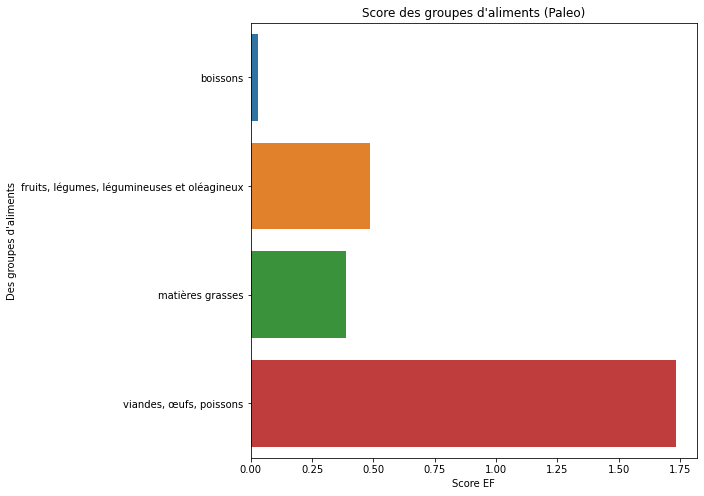

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Score des groupes d'aliments (Paleo)")

sns.barplot(y=df_agr_paleo_score.Group_aliment, x = df_agr_paleo_score.Score_EF, data = df_agr_paleo_score)

plt.ylabel("Des groupes d'aliments")
plt.xlabel("Score EF");

In [ ]:
# Calculons le score de l'année par catégorie de produits (Paleo).

a = pd.DataFrame(df_paleo['Catégorie de produit'])
b = pd.DataFrame((df_paleo['Un paleo (%)']*1058.5)/100)
dictionary = ({"Un paleo (%)" :"Un paleo (kg/par an)"})
b.rename(columns = dictionary , inplace=True)
df_paleo_par_an = pd.concat([a, b],  axis=1)

df_paleo_par_an

,Catégorie de produit,Un paleo (kg/par an)
0,Produits laitiers,0.000
1,Fruits et légumes,232.870
2,"Viandes, poissons, œufs",127.020
3,Produits céréales,0.000
4,Eaux et autres boissons,582.175
5,Autres,116.435


Score des Fruits et légumes= 232.870 * 0.487984 = 113,63683408. Score des Eaux et autres boissons = 0.027932 * 582.175 = 16,2613121. Score des Viandes, poissons, œufs = 127.020 * 1.733571 = 220,19818842. Score des Autres = 116.435 * 0.386818 = 45,03915383.

In [ ]:
my_dict2 = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            'Score_par_an' : [0, 113.63683408, 220.19818842, 0, 16.2613121, 45.03915383]}

df_paleo_score_par_an = pd.DataFrame(my_dict2)
df_paleo_score_par_an

,Catégorie de produit,Score_par_an
0,Produits laitiers,0.000000
1,Fruits et légumes,113.636834
2,"Viandes, poissons, œufs",220.198188
3,Produits céréales,0.000000
4,Eaux et autres boissons,16.261312
5,Autres,45.039154


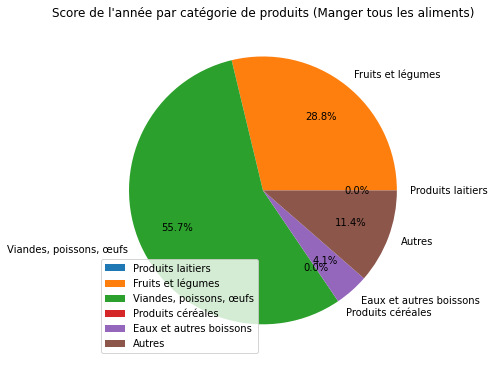

In [ ]:
plt.figure(figsize = (6,8))

plt.title("Score de l'année par catégorie de produits (Manger tous les aliments)")

plt.pie(df_paleo_score_par_an['Score_par_an'], labels=df_paleo_score_par_an['Catégorie de produit'].values, 
        autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_paleo_score_par_an.Score_par_an.mean()
print("Pour toutes les paleo, le score moyen pour l'année est", df_paleo_score_par_an.Score_par_an.mean())

Pour toutes les paleo, le score moyen pour l'année est 65.85591473833334


À l'époque moderne, le régime céto gagne en popularité. Le régime céto, ou régime cétogène, est un régime pauvre en glucides et riche en graisses. Le régime céto peut aider à réduire la glycémie, à augmenter la sensibilité à l'insuline, à se sentir mieux et à perdre du poids en modifiant le métabolisme. Mais comment un tel régime affecte-t-il l'environnement ?

In [ ]:
my_dict = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            
           'Un céto (%)': [6,10,18,0,55,11]}

df_céto= pd.DataFrame(my_dict)
df_céto   

,Catégorie de produit,Un céto (%)
0,Produits laitiers,6
1,Fruits et légumes,10
2,"Viandes, poissons, œufs",18
3,Produits céréales,0
4,Eaux et autres boissons,55
5,Autres,11


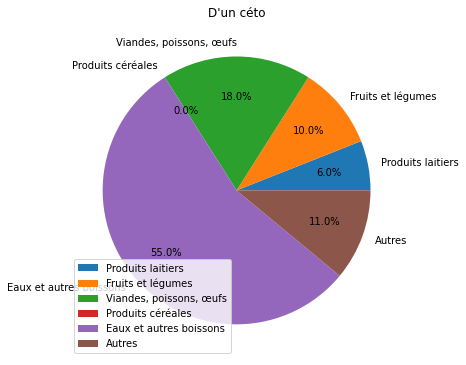

In [ ]:
plt.figure(figsize = (6,8))

plt.title("D'un céto")

plt.pie(df_céto['Un céto (%)'], labels=df_céto['Catégorie de produit'].values, autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_agr_céto = df_agr[(df_agr.Group_aliment == 'fruits, légumes, légumineuses et oléagineux')| 
                (df_agr.Group_aliment == 'viandes, œufs, poissons')| (df_agr.Group_aliment == 'boissons')|
                (df_agr.Group_aliment == 'matières grasses')|
                (df_agr.Group_aliment == 'lait et produits laitiers')]

In [ ]:
df_agr_céto.Sous_group_aliment.unique()

array(['fromages', 'fruits',
       'produits à base de poissons et produits de la mer',
       'viandes cuites', 'viandes crues', 'boisson alcoolisées',
       'fruits à coque et graines oléagineuses', 'poissons crus',
       'charcuteries', 'légumes', 'pommes de terre et autres tubercules',
       'poissons cuits', 'beurres', 'huiles et graisses végétales',
       'autres produits à base de viande', 'boissons sans alcool',
       'produits laitiers frais et assimilés',
       'mollusques et crustacés cuits', 'mollusques et crustacés crus',
       'crèmes et spécialités à base de crème', 'eaux', 'légumineuses',
       'autres matières grasses', 'huiles de poissons', 'laits',
       'margarines', 'œufs'], dtype=object)

In [ ]:
df_agr_céto = df_agr_céto[(df_agr_céto.Sous_group_aliment == 'fromages')| 
                  (df_agr_céto.Sous_group_aliment == 'produits à base de poissons et produits de la mer')|
                  (df_agr_céto.Sous_group_aliment == 'viandes cuites')|
                  (df_agr_céto.Sous_group_aliment == 'viandes crues')|
                  (df_agr_céto.Sous_group_aliment == 'fruits à coque et graines oléagineuses')|
                  (df_agr_céto.Sous_group_aliment == 'poissons crus')|
                  (df_agr_céto.Sous_group_aliment == 'charcuteries')|
                  (df_agr_céto.Sous_group_aliment == 'légumes')|
                  (df_agr_céto.Sous_group_aliment == 'poissons cuits')|
                  (df_agr_céto.Sous_group_aliment == 'huiles et graisses végétales')|
                  (df_agr_céto.Sous_group_aliment == 'autres produits à base de viande')|
                  (df_agr_céto.Sous_group_aliment == 'mollusques et crustacés cuits')|
                  (df_agr_céto.Sous_group_aliment == 'mollusques et crustacés crus')|
                  (df_agr_céto.Sous_group_aliment == 'eaux')|
                  (df_agr_céto.Sous_group_aliment == 'autres matières grasses')|
                  (df_agr_céto.Sous_group_aliment == 'huiles de poissons')|
                   (df_agr_céto.Sous_group_aliment == 'margarines')|
                   (df_agr_céto.Sous_group_aliment == 'œufs')|
                 (df_agr_céto.Sous_group_aliment == 'crèmes et spécialités à base de crème')]

In [ ]:
df_agr_céto_score = df_agr_céto.groupby("Group_aliment", as_index = False).agg({"Score_EF" : "mean"})
df_agr_céto_score.sort_values(["Score_EF"], ascending = False)

,Group_aliment,Score_EF
4,"viandes, œufs, poissons",1.626342
2,lait et produits laitiers,0.618621
3,matières grasses,0.432667
1,"fruits, légumes, légumineuses et oléagineux",0.320833
0,boissons,0.027932


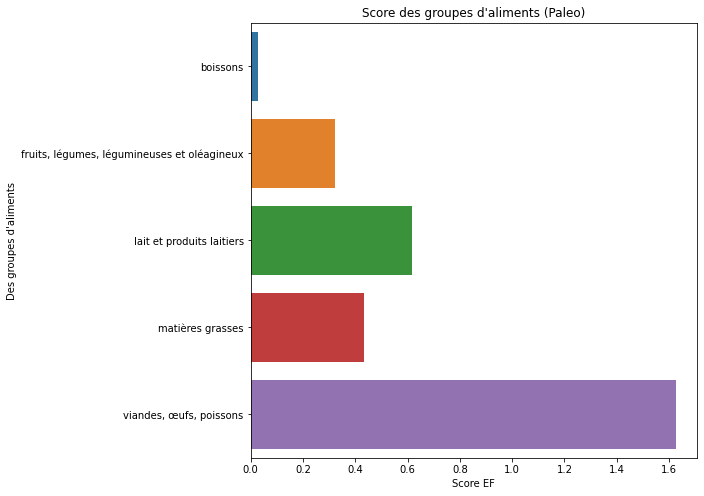

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Score des groupes d'aliments (Paleo)")

sns.barplot(y=df_agr_céto_score.Group_aliment, x = df_agr_céto_score.Score_EF, data = df_agr_céto_score)

plt.ylabel("Des groupes d'aliments")
plt.xlabel("Score EF");

In [ ]:
# Calculons le score de l'année par catégorie de produits (céto).

a = pd.DataFrame(df_céto['Catégorie de produit'])
b = pd.DataFrame((df_céto['Un céto (%)']*1058.5)/100)
dictionary = ({"Un céto (%)" :"Un céto (kg/par an)"})
b.rename(columns = dictionary , inplace=True)
df_céto_par_an = pd.concat([a, b],  axis=1)

df_céto_par_an

,Catégorie de produit,Un céto (kg/par an)
0,Produits laitiers,63.510
1,Fruits et légumes,105.850
2,"Viandes, poissons, œufs",190.530
3,Produits céréales,0.000
4,Eaux et autres boissons,582.175
5,Autres,116.435


Score des Fruits et légumes= 105.850 * 0.320833 = 33,96017305. Score des Eaux et autres boissons = 0.027932 * 582.175 = 16,2613121. Score des Viandes, poissons, œufs = 190.530 * 1.626342 = 309,86694126. Score des Autres = 116.435 * 0.432667 = 50,377582145. Score des Produits laitiers = 63.510 * 0.619026 = 39,31434126.

In [ ]:
my_dict2 = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            'Score_par_an' : [39.31434126, 33.96017305, 309.86694126, 0, 16.2613121, 50.377582145]}

df_céto_score_par_an = pd.DataFrame(my_dict2)
df_céto_score_par_an

,Catégorie de produit,Score_par_an
0,Produits laitiers,39.314341
1,Fruits et légumes,33.960173
2,"Viandes, poissons, œufs",309.866941
3,Produits céréales,0.000000
4,Eaux et autres boissons,16.261312
5,Autres,50.377582


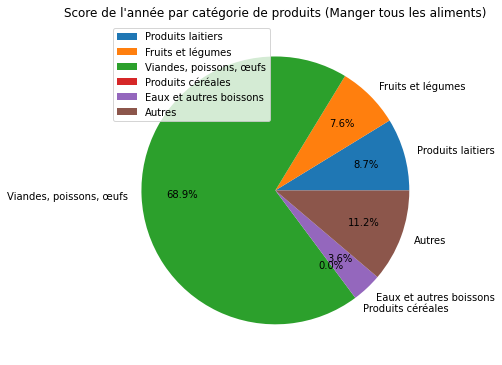

In [ ]:
plt.figure(figsize = (6,8))

plt.title("Score de l'année par catégorie de produits (Manger tous les aliments)")

plt.pie(df_céto_score_par_an['Score_par_an'], labels=df_céto_score_par_an['Catégorie de produit'].values, 
        autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_céto_score_par_an.Score_par_an.mean()
print("Pour toutes les céto, le score moyen pour l'année est", df_céto_score_par_an.Score_par_an.mean())

Pour toutes les céto, le score moyen pour l'année est 74.96339163583333


Considérez un score pour la consommation locale. Pour cela, nous n'envisagerons pas un score pour le transport.

In [ ]:
df_agr1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Agribalyse 3.0/AGRIBALYSE3.0.1_vf.xlsm', sheet_name=2, header=3)

df_agr1=df_agr1.iloc[0:, 0:14]

dictionary={"Code AGB":"Code_AGB",
    "Code CIQUAL":"Code_CIQUAL",
    "Groupe d'aliment":"Group_aliment",
    "Sous-groupe d'aliment":"Sous_group_aliment",
    "Nom du Produit en Français":"Nom_produit",
    "LCI Name":"LCI",
    "Nom et code":"Nom_et_code",
    "Agriculture": "Score_agriculture",
    "Transformation": "Score_transformation",
    "Emballage": "Score_emballage",
    "Transport": "Score_transport",
    "Supermarché et distribution": "Score_supermarché_et_distribution",
    "Consommation": "Score_consommation"}
df_agr1.rename(columns=dictionary, inplace=True)
df_agr1.head(2)

,Code_AGB,Code_CIQUAL,Group_aliment,Sous_group_aliment,Nom_produit,LCI,DQR,Score_agriculture,Score_transformation,Score_emballage,Score_transport,Score_supermarché_et_distribution,Score_consommation,Total
0,12112,12112,lait et produits laitiers,fromages,Abondance,"Abondance cheese, from cow's milk",2.24,0.470679,0.046274,0.019721,0.020615,0.008827,0.002429,0.568767
1,13712,13712,"fruits, légumes, légumineuses et oléagineux",fruits,"Abricot au sirop léger, appertisé, égoutté","Apricot, canned in light syrup, drained",2.46,0.061297,0.075215,0.034667,0.017515,0.016504,0.010169,0.215366


In [ ]:
df_agr1["Score_total_local"] = df_agr1['Score_agriculture']+df_agr1.Score_transformation+df_agr1.Score_emballage+df_agr1.Score_emballage+df_agr1.Score_consommation

In [ ]:
df_agr1.Group_aliment.unique()

array(['lait et produits laitiers',
       'fruits, légumes, légumineuses et oléagineux',
       'viandes, œufs, poissons',
       'aides culinaires et ingrédients divers', 'boissons',
       'entrées et plats composés', 'produits céréaliers',
       'produits sucrés', 'glaces et sorbets', 'matières grasses',
       'aliments infantiles'], dtype=object)

In [ ]:
df_agr_conso_local = df_agr1[(df_agr1.Group_aliment == 'fruits, légumes, légumineuses et oléagineux')| 
                (df_agr1.Group_aliment == 'viandes, œufs, poissons')| (df_agr1.Group_aliment == 'produits céréaliers')|
                (df_agr1.Group_aliment == 'aides culinaires et ingrédients divers')|(df_agr1.Group_aliment == 'boissons')|
                (df_agr1.Group_aliment == 'lait et produits laitiers')| (df_agr1.Group_aliment == 'produits sucrés')|
                (df_agr1.Group_aliment == 'glaces et sorbets')| (df_agr1.Group_aliment == 'matières grasses')]

In [ ]:
df_agr_conso_local_score = df_agr_conso_local.groupby("Group_aliment", as_index = False).agg({"Score_total_local" : "mean"})
df_agr_conso_local_score.sort_values(["Score_total_local"], ascending = False)

,Group_aliment,Score_total_local
8,"viandes, œufs, poissons",1.605084
7,produits sucrés,0.776736
5,matières grasses,0.551632
4,lait et produits laitiers,0.487790
0,aides culinaires et ingrédients divers,0.392232
6,produits céréaliers,0.364298
3,glaces et sorbets,0.279749
2,"fruits, légumes, légumineuses et oléagineux",0.259737
1,boissons,0.192763


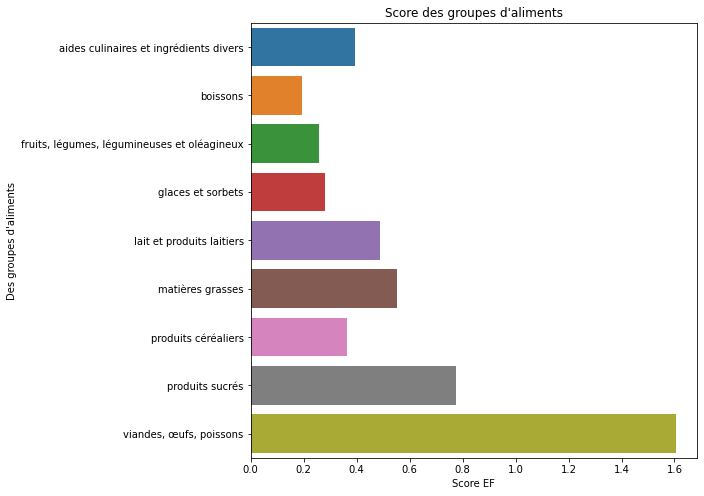

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Score des groupes d'aliments")

sns.barplot(y=df_agr_conso_local_score.Group_aliment, x = df_agr_conso_local_score.Score_total_local, 
            data = df_agr_conso_local_score)

plt.ylabel("Des groupes d'aliments")
plt.xlabel("Score EF");

Score des Produits laitiers = 63.510 * 0.487790 = 30,9795429. Score des Fruits et légumes= 169.360 * 0.259737 = 43,98905832. Score des boisson = 0.192763 * 582.175 = 112,221799525. Score des Viandes, poissons, œufs = 63.510 * 1.605084 = 101,93888484. Score des Produits céréales = 63.510 * 0.364298 = 23,13656598. Score des Autres = 116.435 * ((0.392232 + 0.279749 + 0.551632 + 0.776736)/4) = 58,22765895375.

In [ ]:
my_dict2 = {'Catégorie de produit' : ["Produits laitiers", "Fruits et légumes", "Viandes, poissons, œufs", "Produits céréales", 
                                     "Eaux et autres boissons","Autres"],
            'Score_par_an' : [30.9795429, 43.98905832, 101.93888484, 23.13656598, 112.221799525, 58.22765895375]}

df_agr_local_score_par_an = pd.DataFrame(my_dict2)
df_agr_local_score_par_an

,Catégorie de produit,Score_par_an
0,Produits laitiers,30.979543
1,Fruits et légumes,43.989058
2,"Viandes, poissons, œufs",101.938885
3,Produits céréales,23.136566
4,Eaux et autres boissons,112.221800
5,Autres,58.227659


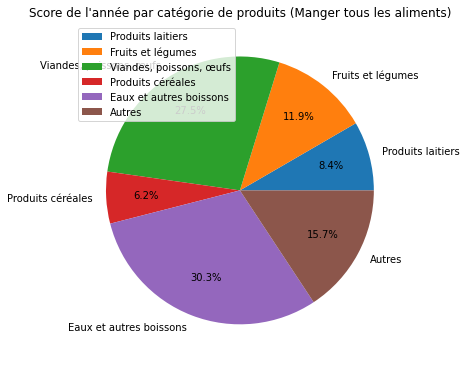

In [ ]:
plt.figure(figsize = (6,8))

plt.title("Score de l'année par catégorie de produits (Manger tous les aliments)")

plt.pie(df_agr_local_score_par_an['Score_par_an'], labels=df_agr_local_score_par_an['Catégorie de produit'].values, 
        autopct='%1.1f%%', labeldistance = 1.1,
        pctdistance = 0.7)


plt.legend(loc = 'best');

In [ ]:
df_agr_local_score_par_an.Score_par_an.mean()
print("Pour la consommation locale, le score moyen pour l'année est", df_agr_local_score_par_an.Score_par_an.mean())

Pour la consommation locale, le score moyen pour l'année est 61.748918419791664


Les graphiques montrent visuellement la différence entre les scores en fonction de la culture alimentaire. Pour toutes les catégories d'aliments, le score moyen pour l'année est 62.56467437895833. Pour le flexitarisme, le score moyen pour l'année est 55.48076897895832. Pour les végétariens, le score moyen pour l'année est 49.538018756666666. Pour les végétaliens, le score moyen pour l'année est 43.5032650375. Pour toutes les paléo, le score moyen pour l'année est 65.85591473833334. Pour toutes les céto, le score moyen pour l'année est 74.96339163583333. Pour la consommation locale, le score moyen pour l'année est 61.748918419791664.

In [ ]:
my_dict5 = {'Culture_alimentaire' : ["Toutes les catégories d'aliments", "Flexitarien", 'Végétarien', 'Vegan', 'Paléo',
                                     'Céto', 'Consommation locale' ],
            'Score_par_an' : [62.56467437895833, 55.48076897895832, 49.538018756666666, 43.5032650375, 65.85591473833334,
                             74.96339163583333, 61.748918419791664]}

df = pd.DataFrame(my_dict5)
df

,Culture_alimentaire,Score_par_an
0,Toutes les catégories d'aliments,62.564674
1,Flexitarien,55.480769
2,Végétarien,49.538019
3,Vegan,43.503265
4,Paléo,65.855915
5,Céto,74.963392
6,Consommation locale,61.748918


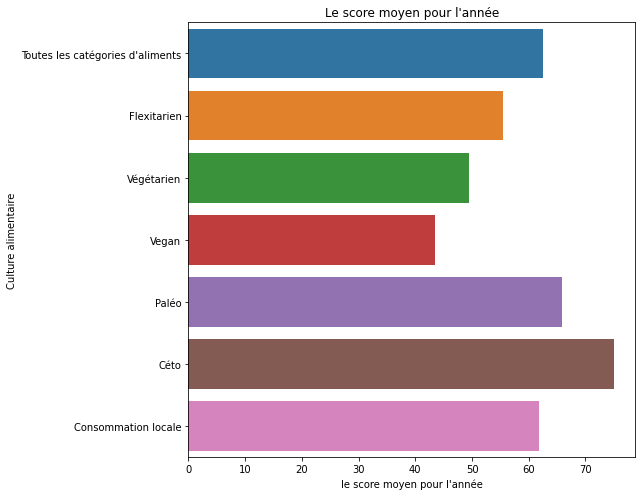

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Le score moyen pour l'année")

sns.barplot(x=df.Score_par_an, y = df.Culture_alimentaire, data = df)

plt.xlabel("le score moyen pour l'année")
plt.ylabel("Culture alimentaire");